<a href="https://colab.research.google.com/github/lucasmedss/energy-consumption-analysis/blob/main/01_exploracao_consumo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este notebook apresenta uma análise exploratória do consumo de energia elétrica em prédios públicos, com foco em identificar padrões temporais e diferenças de comportamento entre edificações.

A proposta é construir uma leitura progressiva dos dados: começamos com uma visão geral, avançamos para recortes por prédio e período, e finalizamos com uma discussão dos padrões observados.


# Configuração do Ambiente


In [1]:
# Configuração do Ambiente
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
sns.set_theme(style="whitegrid")


# Carregamento dos dados


In [ ]:
url = "https://raw.githubusercontent.com/lucasmedss/peca/main/cg_public_energy_consumption.csv"

df = pd.read_csv(
    url,
    parse_dates=["timestamp"],
    dtype={
        "consumption_kwh": "float32",
        "building": "string"
    }
)


# Visão geral do dataset

## Colunas:
* **`consumption_kwh`**: Consumo de energia elétrica (em kWh) referente ao intervalo do registro.
* **`timestamp`**: Carimbo de data e hora da medição (granularidade de 15 minutos).
* **`building`**: Identificação da unidade consumidora, categorizada em:
    * **SAMU**: Serviço de Atendimento Móvel de Urgência.
    * **UPA_DIN**: Unidade de Pronto Atendimento.
    * **ESCOLA_FA**: Escola Municipal.
    * **TEATRO_MUN**: Teatro Municipal.

In [3]:
print("Colunas disponíveis:", df.columns.tolist())
print("Amostra inicial:")
df.head()

Colunas disponíveis: ['timestamp', 'consumption_kwh', 'building']
Amostra inicial:


,timestamp,consumption_kwh,building
0,2023-01-01 00:00:00,0.303551,ESCOLA_FA
1,2023-01-01 00:00:00,4.963575,UPA_DIN
2,2023-01-01 00:15:00,0.331344,ESCOLA_FA
3,2023-01-01 00:15:00,4.279458,UPA_DIN
4,2023-01-01 00:30:00,0.312109,ESCOLA_FA


In [4]:
tabela_periodo_predio = (
    df.groupby("building", dropna=False)
      .agg(
          inicio_periodo=("timestamp", "min"),
          fim_periodo=("timestamp", "max"),
          quantidade_registros=("timestamp", "size")
      )
      .reset_index()
)

tabela_periodo_predio = tabela_periodo_predio[["building", "inicio_periodo", "fim_periodo", "quantidade_registros"]]
tabela_periodo_predio = tabela_periodo_predio.sort_values("building").reset_index(drop=True)

tabela_periodo_predio


,building,inicio_periodo,fim_periodo,quantidade_registros
0,ESCOLA_FA,2023-01-01 00:00:00,2025-12-31 23:45:00,105216
1,SAMU,2024-07-01 00:00:00,2025-12-31 23:45:00,52704
2,TEATRO_MUN,2024-07-11 10:45:00,2025-12-31 23:45:00,51701
3,UPA_DIN,2023-01-01 00:00:00,2025-12-31 23:45:00,105216


# Pré-processamento

## Objetivo desta etapa

- Padronizar o tratamento temporal em um único ponto do notebook.
- Evitar repetição de código em cada análise.

Essa etapa define variáveis que seriam repetidas ao longo dos blocos de código,
evitando repetição desnecessária.


In [5]:
CORES_PREDIOS = {
    "UPA_DIN": "#00CC96",
    "ESCOLA_FA": "#003366",
    "SAMU": "#FF4B4B",
    "TEATRO_MUN": "#6C3483"
}

MESES_PT = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}

ORDEM_MESES_PT = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

DIAS_PT = {
    'Sunday': 'Domingo', 'Monday': 'Segunda-feira', 'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira', 'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira', 'Saturday': 'Sábado'
}

ORDEM_DIAS_PT = ["Domingo", "Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado"]


def preparar_dados(df):
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["ano_mes"] = df["timestamp"].dt.to_period("M")
    df["ano"] = df["timestamp"].dt.year
    df["mes"] = df["timestamp"].dt.month
    return df


df = preparar_dados(df)


### Conversões temporais usadas no notebook

- `timestamp -> ano_mes (Period[M])`: permite agregação mensal sem perder a referência temporal.
- `Period -> string`: útil para exibir rótulos no eixo X de gráficos categóricos.
- Granularidade de 15 minutos, diária e mensal: cada nível responde perguntas diferentes sobre o consumo.


In [6]:
def plot_consumo_mensal(dados, titulo, cor, ax=None):
    if ax is None:
        plt.figure(figsize=(10, 5))
        ax = plt.gca()

    sns.barplot(
        data=dados,
        x="ano_mes_str",
        y="consumption_kwh",
        color=cor,
        edgecolor="black",
        linewidth=0.5,
        ax=ax
    )
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_ylabel("Consumo (kWh)")
    ax.set_xlabel("Ano-Mês")
    sns.despine(ax=ax)
    return ax


def plot_barra_com_hue(
    dados,
    x,
    y,
    titulo,
    xlabel,
    ylabel,
    hue=None,
    palette="viridis",
    order=None,
    figsize=(12, 6),
    legend_title=None,
    show_legend=True,
    rotation=0
):
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=dados,
        x=x,
        y=y,
        hue=hue,
        palette=palette,
        order=order,
        edgecolor="black",
        linewidth=0.5
    )

    plt.title(titulo, fontsize=16, pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=rotation)

    if hue is not None and show_legend:
        plt.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left')
    else:
        plt.legend([], [], frameon=False)

    sns.despine()
    plt.tight_layout()
    plt.show()


# 1. Análise mensal geral

## Objetivo desta etapa

- Agregar o consumo por mês e por edificação.
- Observar tendências de médio prazo e possíveis comportamentos sazonais.
- Comparar visualmente o perfil mensal dos prédios em um painel único.

### Por que agregamos por mês?

Os dados de 15 minutos capturam variações de curto prazo, mas podem dificultar a leitura de tendências amplas. Ao somar por mês, reduzimos ruído e destacamos padrões sazonais e mudanças estruturais de consumo.

### Nota metodológica sobre `sharey=True` e `sharey=False`

- `sharey=True`: todos os subgráficos usam a mesma escala no eixo Y, facilitando comparação direta de magnitude.
- `sharey=False`: cada subgráfico ajusta sua própria escala, facilitando leitura do formato interno de cada série.


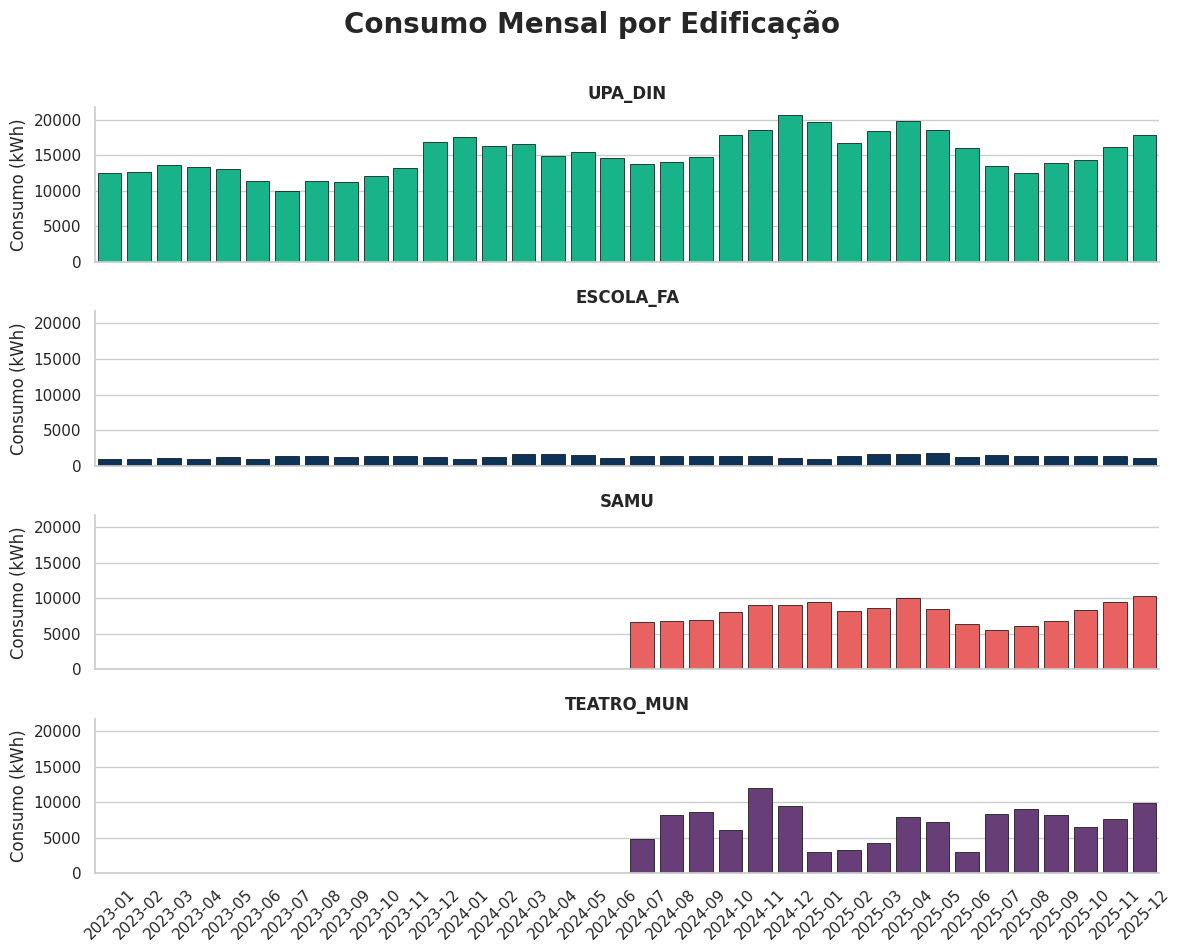

In [7]:
consumo_mensal = (
    df.groupby(["building", "ano_mes"])["consumption_kwh"]
      .sum()
      .reset_index()
)
consumo_mensal["ano_mes_str"] = consumo_mensal["ano_mes"].astype(str)

predios = ["UPA_DIN", "ESCOLA_FA", "SAMU", "TEATRO_MUN"]

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle("Consumo Mensal por Edificação", fontsize=20, fontweight='bold', y=0.98)

for i, predio in enumerate(predios):
    dados_p = consumo_mensal[consumo_mensal["building"] == predio]
    ax = plot_consumo_mensal(
        dados=dados_p,
        titulo=f"{predio}",
        cor=CORES_PREDIOS[predio],
        ax=axes[i]
    )
    ax.set_xlabel("")

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


O gráfico apresenta uma visão comparativa do consumo mensal de energia para cada edificação ao longo do período analisado, evidenciando diferenças de magnitude e padrão entre os prédios.

## 2. Comparação anual

## Objetivo desta etapa

- Comparar meses equivalentes entre anos para a mesma edificação.
- Avaliar sazonalidade anual e possíveis mudanças de patamar de consumo.
- Tornar comparável o comportamento anual (jan a dez) entre diferentes anos.


In [8]:
# =================================================================
# 🔵 PARÂMETROS INTERATIVOS E FILTRAGEM
# =================================================================
edificacao_escolhida = "UPA_DIN"
anos_para_comparar = [2023, 2024, 2025]

# Filtragem dos dados conforme os anos escolhidos
df_anual = df[
    (df["building"] == edificacao_escolhida) &
    (df["ano"].isin(anos_para_comparar))
].copy()

# Agrupamento por ano e mês
consumo_mensal_anual = (
    df_anual.groupby(["ano", "mes"])["consumption_kwh"]
      .sum()
      .reset_index()
)

consumo_mensal_anual["mes_nome"] = consumo_mensal_anual["mes"].map(MESES_PT)
consumo_mensal_anual["ano"] = consumo_mensal_anual["ano"].astype(str)


fig = px.bar(
    consumo_mensal_anual,
    x="mes_nome",
    y="consumption_kwh",
    color="ano",
    barmode="group",
    category_orders={"mes_nome": ORDEM_MESES_PT},
    color_discrete_sequence=px.colors.sequential.Magma,
    title=f"Sazonalidade Anual: Comparativo de Consumo - {edificacao_escolhida}",
    labels={
        "mes_nome": "Mês do Ano",
        "consumption_kwh": "Consumo Total (kWh)",
        "ano": "Ano de Referência"
    },
    hover_data={
        "mes_nome": True,
        "ano": True,
        "consumption_kwh": ":,.0f"
    }
)

fig.update_layout(
    legend_title_text='Ano de Referência',
    plot_bgcolor="rgba(0,0,0,0)",
    hovermode="x unified",
    margin=dict(l=20, r=20, t=60, b=40),
    xaxis={'categoryorder': 'array', 'categoryarray': ORDEM_MESES_PT}
)

fig.show()

O gráfico de exemplo evidencia a comparação do consumo mensal ao longo de três anos distintos, permitindo analisar a sazonalidade, identificar tendências de crescimento ou redução e diferenciar padrões de comportamento entre os períodos. Essa visualização facilita a identificação de meses com maior ou menor demanda, além de possibilitar a observação de variações estruturais no consumo ao longo do tempo.


# 3. Análise por edificação

## Objetivo desta etapa

- Fazer recortes específicos por prédio para análise mais detalhada.
- Investigar comportamento diário dentro de um mês.
- Comparar perfis semanais entre meses para a mesma edificação.


In [9]:
# =================================================================
# 🔵 PARÂMETROS INTERATIVOS
# =================================================================
edificacao_escolhida = "SAMU"
mes_escolhido = "2024-07"

df_mes = df[
    (df["building"] == edificacao_escolhida) &
    (df["ano_mes"].astype(str) == mes_escolhido)
].copy()

if df_mes.empty:
    print(f"⚠️ Sem dados para {edificacao_escolhida} no mês {mes_escolhido}.")
else:
    df_mes["dia"] = df_mes["timestamp"].dt.date
    consumo_por_dia = (
        df_mes.groupby(["dia", "building"])["consumption_kwh"]
            .sum()
            .reset_index()
    )

    consumo_por_dia["dia_so_numero"] = pd.to_datetime(consumo_por_dia["dia"]).dt.strftime('%d')

    fig = px.bar(
        consumo_por_dia,
        x="dia_so_numero",
        y="consumption_kwh",
        color="building",
        color_discrete_map=CORES_PREDIOS,
        title=f"Consumo Diário: {edificacao_escolhida} ({mes_escolhido})",
        labels={
            "dia_so_numero": "Dia do Mês",
            "consumption_kwh": "Consumo Total (kWh)",
            "building": "Edificação"
        },
        hover_data={
            "dia_so_numero": True,
            "consumption_kwh": ":.2f"
        }
    )

    fig.update_layout(
        xaxis_type='category',
        showlegend=False,
        plot_bgcolor="rgba(0,0,0,0)",
        hovermode="x unified",
        margin=dict(l=20, r=20, t=60, b=20)
    )

    fig.show()

O gráfico possibilita analisar a variação do consumo diário ao longo do mês selecionado, permitindo identificar oscilações, padrões e dias de maior ou menor demanda.

## 4. Análise diária por mês


In [10]:
# =================================================================
# 🔵 PARÂMETROS INTERATIVOS E FILTRAGEM
# =================================================================
edificacao_escolhida = "ESCOLA_FA"
meses_para_comparar = ["2024-10", "2024-11", "2024-01"]

# Filtragem e preparação dos dados
df_comp = df[
    (df["building"] == edificacao_escolhida) &
    (df["ano_mes"].astype(str).isin(meses_para_comparar))
].copy()

df_comp["ano_mes"] = df_comp["ano_mes"].astype(str)
df_comp["dia_semana"] = df_comp["timestamp"].dt.day_name().map(DIAS_PT)

resumo_semanal = (
    df_comp.groupby(["dia_semana", "ano_mes"])["consumption_kwh"]
      .mean()
      .reset_index()
)

fig = px.bar(
    resumo_semanal,
    x="dia_semana",
    y="consumption_kwh",
    color="ano_mes",
    barmode="group",
    category_orders={"dia_semana": ORDEM_DIAS_PT},
    color_discrete_sequence=px.colors.sequential.Magma,
    title=f"Perfil Semanal Comparativo: {edificacao_escolhida}",
    labels={
        "dia_semana": "Dia da Semana",
        "consumption_kwh": "Consumo Médio (kWh)",
        "ano_mes": "Mês Referência"
    },
    hover_data={
        "dia_semana": False,
        "ano_mes": True,
        "consumption_kwh": ":.2f"
    }
)

# Ajustes de Layout
fig.update_layout(
    legend_title_text='Mês Referência',
    plot_bgcolor="rgba(0,0,0,0)",
    hovermode="x unified",
    margin=dict(l=20, r=20, t=60, b=20),
    xaxis={'categoryorder': 'array', 'categoryarray': ORDEM_DIAS_PT}
)

fig.show()

O gráfico apresenta o perfil semanal comparativo do consumo médio diário para os meses de referência, permitindo analisar o consumo ao longo dos dias da semana. A visualização destaca padrões recorrentes, como maior consumo em dias úteis e redução nos fins de semana


# 5. Discussão dos padrões

## Objetivo desta etapa

- Analisar intensidade média horária por dia da semana em formato de mapa de calor.
- Identificar janelas de maior carga e diferenças de perfil operacional entre duas edificações.


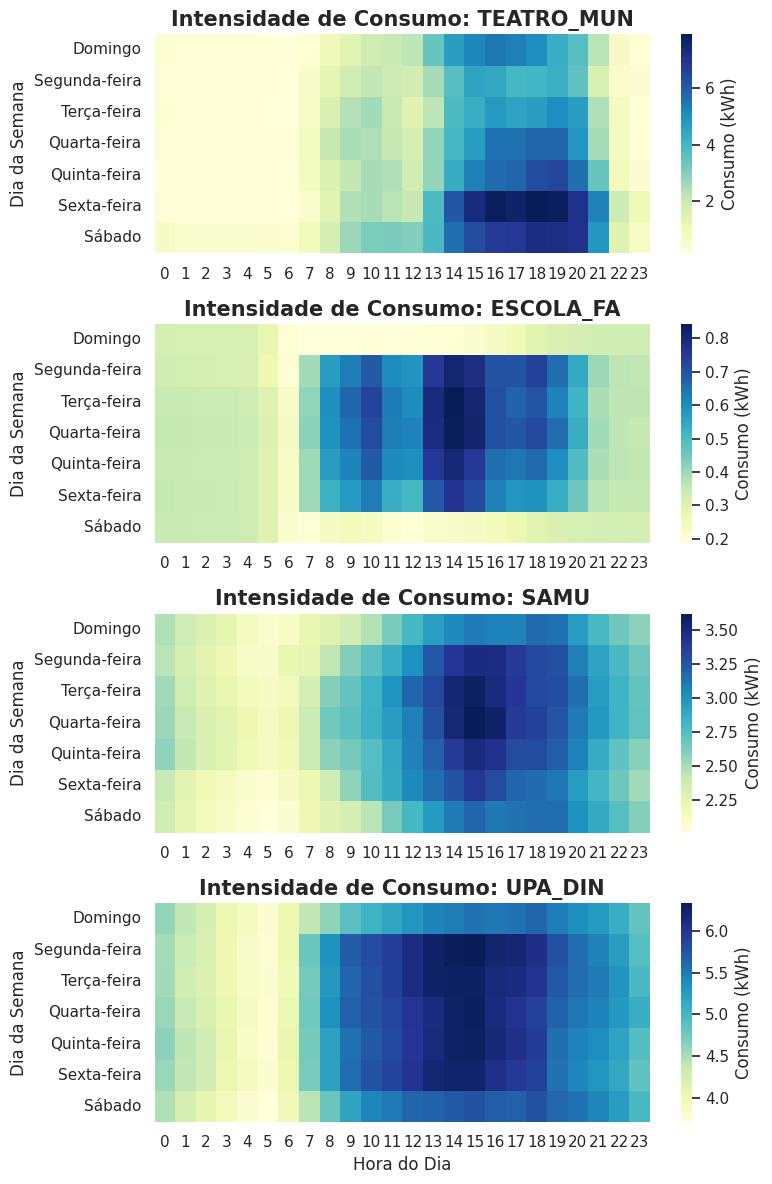

In [14]:
# =============================
# 🔵 PARÂMETROS INTERATIVOS
# Altere aqui para explorar diferentes cenários
# =============================
predio_1 = "TEATRO_MUN"
predio_2 = "ESCOLA_FA"
predio_3 = "SAMU"
predio_4 = "UPA_DIN"


def preparar_matriz(nome_predio, dataframe):
    pivoted = dataframe[dataframe['building'] == nome_predio].copy()
    pivoted['hora'] = pivoted['timestamp'].dt.hour
    pivoted['dia'] = pivoted['timestamp'].dt.day_name().map(DIAS_PT)

    matrix = pivoted.groupby(['dia', 'hora'])['consumption_kwh'].mean().unstack()
    return matrix.reindex(ORDEM_DIAS_PT)


def plot_heatmap_consumo(matrix, titulo, ax):
    sns.heatmap(matrix, cmap="YlGnBu", ax=ax, cbar_kws={'label': 'Consumo (kWh)'})
    ax.set_title(titulo, fontsize=15, fontweight='bold')
    ax.set_ylabel("Dia da Semana")


matrix_1 = preparar_matriz(predio_1, df)
matrix_2 = preparar_matriz(predio_2, df)
matrix_3 = preparar_matriz(predio_3, df)
matrix_4 = preparar_matriz(predio_4, df)

fig, axes = plt.subplots(4, 1, figsize=(8, 12))
plot_heatmap_consumo(matrix_1, f"Intensidade de Consumo: {predio_1}", axes[0])
axes[0].set_xlabel("")
plot_heatmap_consumo(matrix_2, f"Intensidade de Consumo: {predio_2}", axes[1])
axes[1].set_xlabel("")
plot_heatmap_consumo(matrix_3, f"Intensidade de Consumo: {predio_3}", axes[2])
axes[2].set_xlabel("")
plot_heatmap_consumo(matrix_4, f"Intensidade de Consumo: {predio_4}", axes[3])
axes[3].set_xlabel("Hora do Dia")

plt.tight_layout()
plt.show()


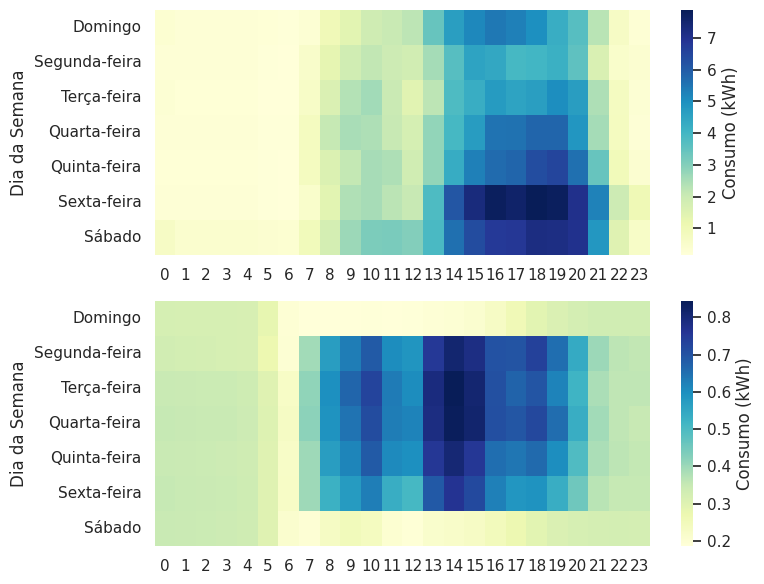

In [18]:
# =============================
# 🔵 PARÂMETROS INTERATIVOS
# Altere aqui para explorar diferentes cenários
# =============================
predio_1 = "TEATRO_MUN"
predio_2 = "ESCOLA_FA"


def preparar_matriz(nome_predio, dataframe):
    pivoted = dataframe[dataframe['building'] == nome_predio].copy()
    pivoted['hora'] = pivoted['timestamp'].dt.hour
    pivoted['dia'] = pivoted['timestamp'].dt.day_name().map(DIAS_PT)

    matrix = pivoted.groupby(['dia', 'hora'])['consumption_kwh'].mean().unstack()
    return matrix.reindex(ORDEM_DIAS_PT)


def plot_heatmap_consumo(matrix, titulo, ax):
    sns.heatmap(matrix, cmap="YlGnBu", ax=ax, cbar_kws={'label': 'Consumo (kWh)'})
    ax.set_title(titulo, fontsize=15, fontweight='bold')
    ax.set_ylabel("Dia da Semana")


matrix_1 = preparar_matriz(predio_1, df)
matrix_2 = preparar_matriz(predio_2, df)

fig, axes = plt.subplots(2, 1, figsize=(8, 6))
plot_heatmap_consumo(matrix_1, "",axes[0])
axes[0].set_xlabel("")
plot_heatmap_consumo(matrix_2, "", axes[1])
axes[1].set_xlabel("")

plt.tight_layout()
plt.show()


No gráfico, observa-se um comportamento contrastante entre as edificações, diretamente ligado às suas atividades. A escola possui o padrão mais regular, concentrando o consumo nos dias úteis e em horário comercial. O Teatro Municipal destaca-se pelos picos nas sextas e sábados (do final da tarde à noite), refletindo sua agenda cultural. Já as unidades de saúde (SAMU e UPA) compartilham um perfil ininterrupto: mantêm um consumo elevado todos os dias da semana, desde o início da manhã até a noite. Analisando esses perfis de forma integrada, fica evidente como a natureza de cada serviço dita a sua curva de demanda energética.